### AWS SageMaker Experiment with MNIST Handwritten Digits Classification
by Keith Baskervillle 

This demo shows how you can use the [SageMaker Experiments Python SDK](https://sagemaker-experiments.readthedocs.io/en/latest/) to organize, track, compare, and evaluate your machine learning (ML) model training experiments. 

We demonstrate these capabilities through an MNIST handwritten digits classification example. The experiment is organized as follows:

1. Download and prepare the MNIST dataset.
2. Train a Convolutional Neural Network (CNN) Model. Tune the hyperparameter that configures the number of hidden channels in the model. Track the parameter configurations and resulting model accuracy using the SageMaker Experiments Python SDK.
3. Finally use the search and analytics capabilities of the SDK to search, compare and evaluate the performance of all model versions generated from model tuning in Step 2.
4. We also show an example of tracing the complete lineage of a model version: the collection of all the data pre-processing and training configurations and inputs that went into creating that model version.

Make sure you select the `Python 3 (Data Science)` kernel in Studio, or `conda_amazonei_latest_p37` in a notebook instance.




### Runtime
This notebook takes approximately 25 minutes to run.

## Install modules


In [3]:
import sys

## Install the SageMaker Experiments Python SDK

In [4]:
!{sys.executable} -m pip install sagemaker-experiments==0.1.35


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


## Install PyTorch

In [5]:
!{sys.executable} -m pip install torch==1.1.0
!{sys.executable} -m pip install torchvision==0.2.2
!{sys.executable} -m pip install pillow==6.2.2
!{sys.executable} -m pip install --upgrade sagemaker

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


### Setup 

In [6]:
import time

import boto3
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

set_matplotlib_formats("retina")

/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [8]:
sm_sess = sagemaker.Session()
sess = sm_sess.boto_session
sm = sm_sess.sagemaker_client
role = get_execution_role()

## Download the dataset
We download the MNIST handwritten digits dataset, and then apply a transformation on each image.

In [9]:
bucket = sm_sess.default_bucket()
prefix = "DEMO-mnist"
print("Using S3 location: s3://" + bucket + "/" + prefix + "/")

datasets.MNIST.urls = [
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/train-images-idx3-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/train-labels-idx1-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/t10k-images-idx3-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/t10k-labels-idx1-ubyte.gz",
]

# Download the dataset to the ./mnist folder, and load and transform (normalize) them
train_set = datasets.MNIST(
    "mnist",
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=True,
)

test_set = datasets.MNIST(
    "mnist",
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=False,
)

Using S3 location: s3://sagemaker-us-west-2-148596524235/DEMO-mnist/


View an example image from the dataset.

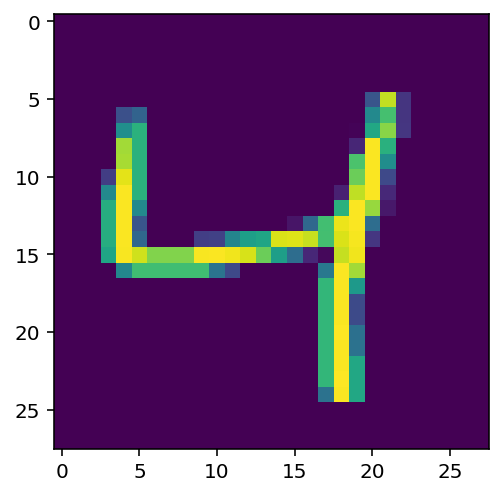

In [10]:
plt.imshow(train_set.data[2].numpy())


After transforming the images in the dataset, we upload it to S3.

In [11]:
inputs = sagemaker.Session().upload_data(path="mnist", bucket=bucket, key_prefix=prefix)


Now let's track the parameters from the data pre-processing step.



In [12]:
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters(
        {
            "normalization_mean": 0.1307,
            "normalization_std": 0.3081,
        }
    )
    # We can log the S3 uri to the dataset we just uploaded
    tracker.log_input(name="mnist-dataset", media_type="s3/uri", value=inputs)

## Step 1: Set up the Experiment
Create an experiment to track all the model training iterations. Experiments are a great way to organize your data science work. You can create experiments to organize all your model development work for: [1] a business use case you are addressing (e.g. create experiment named “customer churn prediction”), or [2] a data science team that owns the experiment (e.g. create experiment named “marketing analytics experiment”), or [3] a specific data science and ML project. Think of it as a “folder” for organizing your “files”.

### Create an Experiment

In [13]:
mnist_experiment = Experiment.create(
    experiment_name=f"mnist-hand-written-digits-classification-{int(time.time())}",
    description="Classification of mnist hand-written digits",
    sagemaker_boto_client=sm,
)
print(mnist_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f9266e10b50>,experiment_name='mnist-hand-written-digits-classification-1659037001',description='Classification of mnist hand-written digits',tags=None,experiment_arn='arn:aws:sagemaker:us-west-2:148596524235:experiment/mnist-hand-written-digits-classification-1659037001',response_metadata={'RequestId': '68b1336e-8854-49d1-9e27-c5c5f432ebe4', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '68b1336e-8854-49d1-9e27-c5c5f432ebe4', 'content-type': 'application/x-amz-json-1.1', 'content-length': '123', 'date': 'Thu, 28 Jul 2022 19:36:40 GMT'}, 'RetryAttempts': 0})


### Step 2: Track Experiment
Now create a Trial for each training run to track its inputs, parameters, and metrics.
While training the CNN model on SageMaker, we experiment with several values for the number of hidden channel in the model. We create a Trial to track each training job run. We also create a TrialComponent from the tracker we created before, and add to the Trial. This enriches the Trial with the parameters we captured from the data pre-processing stage.

In [14]:
from sagemaker.pytorch import PyTorch, PyTorchModel


In [15]:
hidden_channel_trial_name_map = {}


If you want to run the following five training jobs in parallel, you may need to increase your resource limit. Here we run them sequentially.



In [16]:
preprocessing_trial_component = tracker.trial_component


In [17]:
for i, num_hidden_channel in enumerate([2, 5, 10, 20, 32]):
    # Create trial
    trial_name = f"cnn-training-job-{num_hidden_channel}-hidden-channels-{int(time.time())}"
    cnn_trial = Trial.create(
        trial_name=trial_name,
        experiment_name=mnist_experiment.experiment_name,
        sagemaker_boto_client=sm,
    )
    hidden_channel_trial_name_map[num_hidden_channel] = trial_name

    # Associate the proprocessing trial component with the current trial
    cnn_trial.add_trial_component(preprocessing_trial_component)

    # All input configurations, parameters, and metrics specified in
    # the estimator definition are automatically tracked
    estimator = PyTorch(
        py_version="py3",
        entry_point="./mnist.py",
        role=role,
        sagemaker_session=sagemaker.Session(sagemaker_client=sm),
        framework_version="1.1.0",
        instance_count=1,
        instance_type="ml.c4.xlarge",
        hyperparameters={
            "epochs": 2,
            "backend": "gloo",
            "hidden_channels": num_hidden_channel,
            "dropout": 0.2,
            "kernel_size": 5,
            "optimizer": "sgd",
        },
        metric_definitions=[
            {"Name": "train:loss", "Regex": "Train Loss: (.*?);"},
            {"Name": "test:loss", "Regex": "Test Average loss: (.*?),"},
            {"Name": "test:accuracy", "Regex": "Test Accuracy: (.*?)%;"},
        ],
        enable_sagemaker_metrics=True,
    )

    cnn_training_job_name = "cnn-training-job-{}".format(int(time.time()))
    estimator.fit(
        inputs={"training": inputs},
        job_name=cnn_training_job_name,
        experiment_config={
            "TrialName": cnn_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        },
        wait=True,
    )

    # Wait two seconds before dispatching the next training job
    time.sleep(2)

FileNotFoundError: [Errno 2] No such file or directory: './mnist.py'